#Download data set

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle
!kaggle datasets download -d francismon/curated-colon-dataset-for-deep-learning
!unzip -q curated-colon-dataset-for-deep-learning.zip

cp: cannot stat 'kaggle.json': No such file or directory
Dataset URL: https://www.kaggle.com/datasets/francismon/curated-colon-dataset-for-deep-learning
License(s): unknown
curated-colon-dataset-for-deep-learning.zip: Skipping, found more recently modified local copy (use --force to force download)
replace test/0_normal/test_normal_ (1).jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: no
replace test/0_normal/test_normal_ (10).jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: No


#Visualising Images

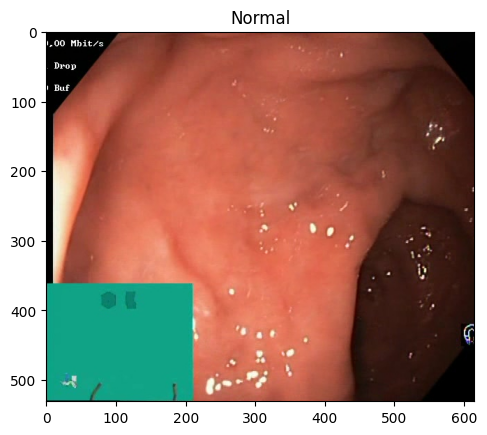

In [ ]:
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
import cv2

def img_show(img_path, title):
    img = cv2.imread(img_path)[:,:,::-1]
    plt.imshow(img)
    plt.title(title)
    plt.show()

img_show('/content/train/0_normal/train_normal_ (1).jpg', 'Normal')

#DATA PREPROCESSING

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
trainPath = '/content/train'
testPath = '/content/test'
valPath = '/content/val'

img_size = (224, 224)
batch_size=16
# Instantiating ImageDataGenerator for train, test and validation sets
train_datagen = ImageDataGenerator(rescale=1./255,zoom_range=0.2,shear_range=0.2)
test_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)


train = train_datagen.flow_from_directory(trainPath,target_size =(224,224),batch_size=16,class_mode='categorical')
test = test_datagen.flow_from_directory(testPath,target_size =(224,224),batch_size=16,class_mode='categorical')
val = val_datagen.flow_from_directory(valPath,target_size =(224,224),batch_size=16,class_mode='categorical')

Found 3200 images belonging to 4 classes.
Found 800 images belonging to 4 classes.
Found 2000 images belonging to 4 classes.


#Data Augumentation

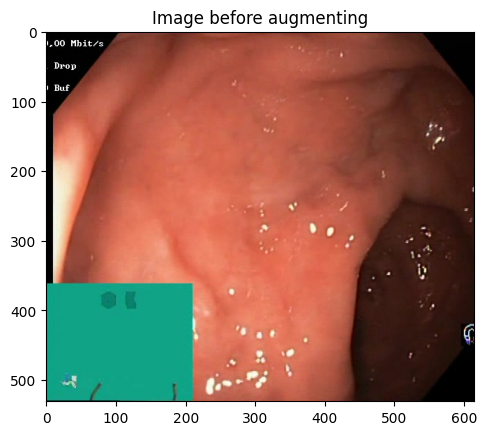

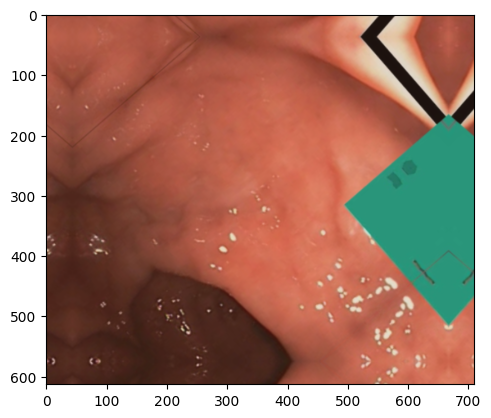

In [ ]:
from tensorflow.keras import layers
import tensorflow as tf

data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomHeight(0.2),
    layers.RandomWidth(0.2),
    layers.RandomContrast(0.2)
], name="data_augmentation")

# Test the augmentation layer
path = "/content/train/0_normal/train_normal_ (1).jpg"
img_show(path, "Image before augmenting")
img = cv2.imread(path)
augmented_img = data_augmentation(tf.expand_dims(img, axis=0))
augmented_img = tf.squeeze((augmented_img)/255.)[:, :, ::-1]

plt.figure()
plt.imshow(augmented_img)
plt.show()

#VGG16

In [1]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.layers import Dense,Flatten
from tensorflow.keras.models import Model

vgg = VGG16(weights='imagenet',include_top=False,input_shape=(224,224,3))
# Freeze VGG16 layers
for layer in vgg.layers:
    layer.trainable = False


x = Flatten()(vgg.output)
output = Dense(4,activation='softmax')(x)
vgg16 = Model(vgg.input,output)

# Compile the model
vgg16.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

vgg16.summary()


58889256/58889256 [==============================] - 1s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                              

In [ ]:
import os

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
base_path = '/content'
model_save_path = os.path.join(base_path, "model/vgg16_model.h5")
##model.fit(train_generator, validation_data=validation_generator, epochs=2)
# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
checkpoint = ModelCheckpoint(model_save_path, monitor='val_loss', save_best_only=True, verbose=1)

# Compile the model
vgg16.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model with callbacks
history = vgg16.fit(
    train,
    validation_data=test,
    epochs=50,
    callbacks=[early_stopping, checkpoint]
)

# Print the model save path
print(f"Model saved at: {model_save_path}")

# Save the model
os.makedirs(os.path.dirname(model_save_path), exist_ok=True)
vgg16.save(model_save_path)

Epoch 1/50
200/200 [==============================] - ETA: 0s - loss: 0.2686 - accuracy: 0.9016
Epoch 1: val_loss improved from inf to 0.32143, saving model to /content/model/vgg16_model.h5
200/200 [==============================] - 70s 323ms/step - loss: 0.2686 - accuracy: 0.9016 - val_loss: 0.3214 - val_accuracy: 0.8737
Epoch 2/50


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


200/200 [==============================] - ETA: 0s - loss: 0.0740 - accuracy: 0.9734
Epoch 2: val_loss did not improve from 0.32143
200/200 [==============================] - 66s 329ms/step - loss: 0.0740 - accuracy: 0.9734 - val_loss: 0.7599 - val_accuracy: 0.7862
Epoch 3/50
200/200 [==============================] - ETA: 0s - loss: 0.0443 - accuracy: 0.9872
Epoch 3: val_loss improved from 0.32143 to 0.20602, saving model to /content/model/vgg16_model.h5
200/200 [==============================] - 64s 321ms/step - loss: 0.0443 - accuracy: 0.9872 - val_loss: 0.2060 - val_accuracy: 0.9150
Epoch 4/50
200/200 [==============================] - ETA: 0s - loss: 0.0622 - accuracy: 0.9747
Epoch 4: val_loss did not improve from 0.20602
200/200 [==============================] - 64s 321ms/step - loss: 0.0622 - accuracy: 0.9747 - val_loss: 0.7834 - val_accuracy: 0.7950
Epoch 5/50
200/200 [==============================] - ETA: 0s - loss: 0.0296 - accuracy: 0.9900
Epoch 5: val_loss did not improve

In [ ]:
vgg16.save('Vgg.h5')
from google.colab import files
files.download("Vgg.h5")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

#Load and Predict

In [ ]:

#load the model
from keras.models import load_model
model = load_model('/content/Vgg.h5')

#Predict
#import the library's
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np
index=['0_normal','1_ulcerative_colitis','2_polyps','3_esophagitis']
Img_path= r'/content/test/3_esophagitis/test_esophagitis_ (109).jpg'
img=image.load_img(Img_path,target_size=(224,224))
x=image.img_to_array(img)
x=np.expand_dims(x,axis=0) #(1,224,224,3)
img_data=preprocess_input(x)
img_data.shape
output=np.argmax(model.predict(img_data), axis=1)
result = index[output[0]]
result

1/1 [==============================] - 1s 1s/step


'3_esophagitis'

Found 800 images belonging to 4 classes.


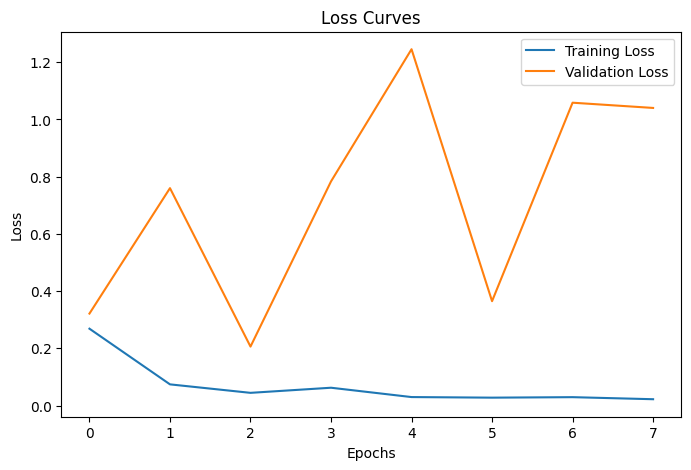

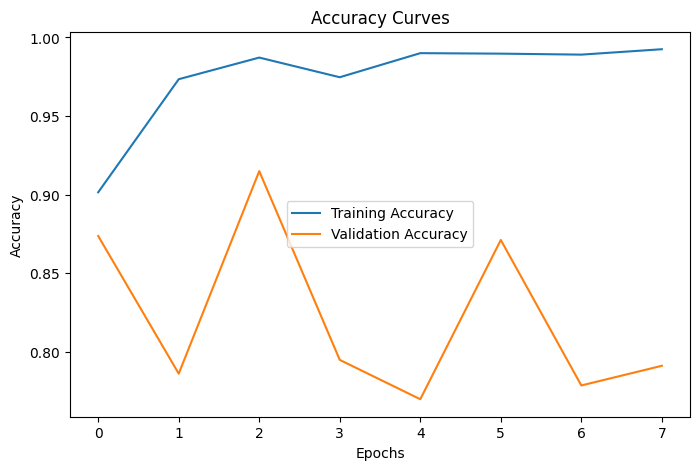

50/50 [==============================] - 7s 145ms/step - loss: 0.2060 - accuracy: 0.9150
Test Loss: 0.20602138340473175
Test Accuracy: 0.9150000214576721
50/50 [==============================] - 6s 124ms/step
Classification Report
                      precision    recall  f1-score   support

            0_normal       0.98      1.00      0.99       200
1_ulcerative_colitis       0.85      0.83      0.84       200
            2_polyps       0.84      0.84      0.84       200
       3_esophagitis       0.98      0.98      0.98       200

            accuracy                           0.92       800
           macro avg       0.91      0.91      0.91       800
        weighted avg       0.91      0.92      0.91       800



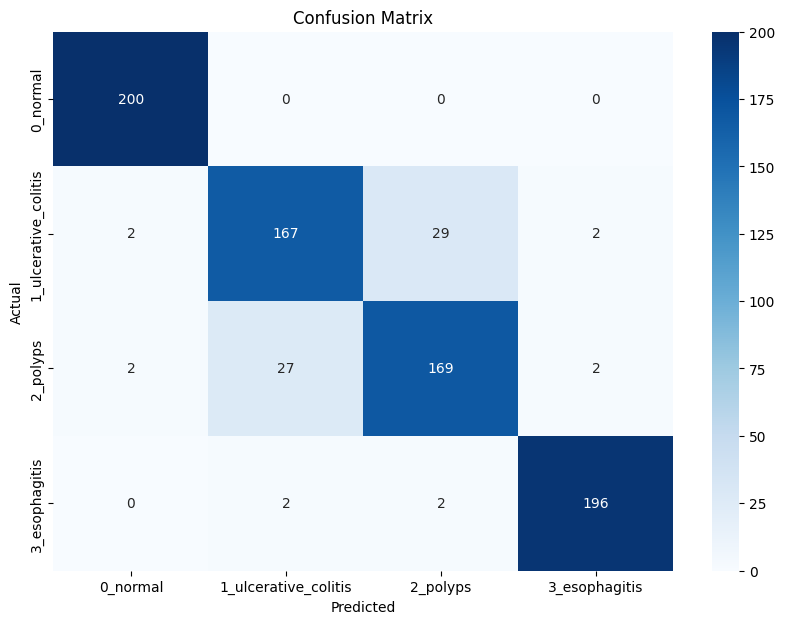

Confusion Matrix:
[[200   0   0   0]
 [  2 167  29   2]
 [  2  27 169   2]
 [  0   2   2 196]]


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

testpath = os.path.join(base_path, "test")
test_datagen = ImageDataGenerator(rescale=1./255)
test = test_datagen.flow_from_directory(
    testpath,
    target_size=(224, 224),
    batch_size=16,
    class_mode='categorical',
    shuffle=False
)

# Plotting loss and accuracy curves
def plot_loss_curves(history):
    # Loss Curves
    plt.figure(figsize=(8, 5))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss Curves')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    # Accuracy Curves
    plt.figure(figsize=(8, 5))
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy Curves')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

plot_loss_curves(history)

# Model evaluation on the test set
test_loss, test_accuracy = model.evaluate(test)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

# Classification report and confusion matrix
y_true = test.classes
y_pred = np.argmax(model.predict(test), axis=-1)

# Extracting class names from the data generator
class_names = list(train.class_indices.keys())

print('Classification Report')
print(classification_report(y_true, y_pred, target_names=class_names))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

print('Confusion Matrix:')
print(cm)